In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import torchvision as tv
from torchvision.datasets import EMNIST
from torchsummary import summary
import torchinfo as tinfo

In [2]:
tf224 = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

In [3]:
tf229 = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 229)),
    tv.transforms.ToTensor()
])

In [4]:
byclass_train_data = EMNIST(
    root='.',
    split='byclass',
    train=True,
    transform=tf224,
    target_transform=None,
    download=False
)

In [5]:
byclass_test_data = EMNIST(
    root='.',
    split='byclass',
    train=False,
    transform=tf224,
    target_transform=None,
    download=False
)

In [6]:
# total train and test samples count
len(byclass_train_data), len(byclass_test_data)

(697932, 116323)

In [7]:
# classes count and last 6 classes
len(byclass_train_data.classes), byclass_train_data.classes[56:]

(62, ['u', 'v', 'w', 'x', 'y', 'z'])

In [8]:
byclass_train_data.data.shape

torch.Size([697932, 28, 28])

In [9]:
byclass_train_data[0][0].shape

torch.Size([3, 224, 224])

In [10]:
trn_labels = byclass_train_data.targets
trn_counts = np.bincount(trn_labels)
trn_weights = 1. / trn_counts
print('train counts:', len(trn_counts))
print('count of 0:', trn_counts[0])
print('count of 1:', trn_counts[1])
print('count of 61:', trn_counts[61])

train counts: 62
count of 0: 34585
count of 1: 38374
count of 61: 2725


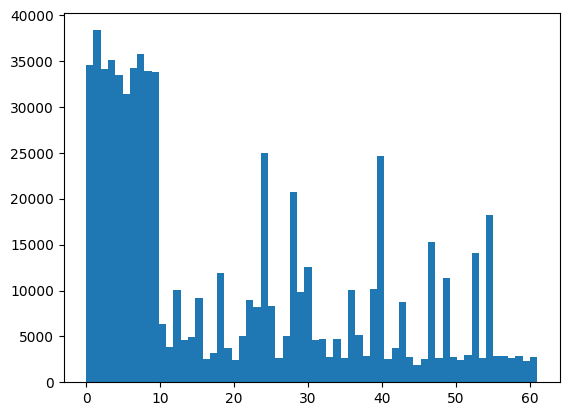

62

In [11]:
# частотность появления цифр в наборе в среднем сильно превышает частотность символов
n_trn_bins = len(byclass_train_data.classes)
plt.hist(trn_labels, bins=n_trn_bins)
plt.show()
n_trn_bins

In [12]:
tst_labels = byclass_test_data.targets
len(tst_labels)

116323

In [13]:
tst_counts = np.bincount(tst_labels)
tst_weights = 1. / tst_counts
print('test counts:', len(tst_counts))
print('count of 0:', tst_counts[0])
print('count of 1:', tst_counts[1])
print('count of 61:', tst_counts[61])

test counts: 62
count of 0: 5778
count of 1: 6330
count of 61: 451


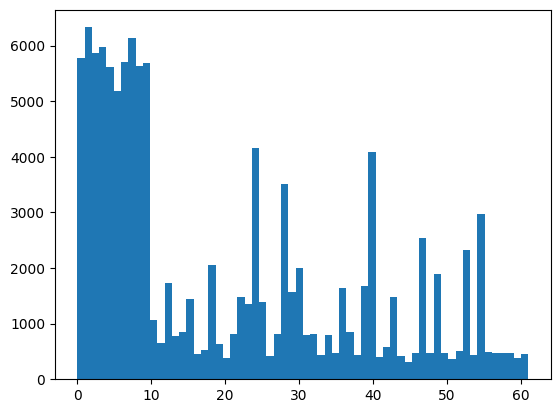

62

In [14]:
# частотность появления цифр в тесте также неоднородна
n_tst_bins = len(byclass_test_data.classes)
plt.hist(tst_labels, bins=n_tst_bins)
plt.show()
n_tst_bins

In [15]:
from torch.utils.data import DataLoader, WeightedRandomSampler

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
# Балансировка классов с помощью WeightedRandomSampler
trn_sample_weights = np.array([trn_weights[t] for t in trn_labels])
trn_sampler = WeightedRandomSampler(weights=trn_sample_weights, num_samples=len(trn_sample_weights))
tst_sample_weights = np.array([tst_weights[t] for t in tst_labels])
tst_sampler = WeightedRandomSampler(weights=tst_sample_weights, num_samples=len(tst_sample_weights))

In [18]:
# train and test datasets
BATCH_SIZE=62*4
dl_train = DataLoader(byclass_train_data, pin_memory=True, sampler=trn_sampler, batch_size=BATCH_SIZE)
dl_test = DataLoader(byclass_test_data, pin_memory=True, sampler=tst_sampler, batch_size=BATCH_SIZE)

In [24]:
# проверим частотность появления цифр (y < 10),
# среди случайных 4*62 значений ожидаем 4*10 = 40 цифр
# прервем после 200 батчей, t / 200 -> 40
t, n = 0, 0
for i, (X, y) in enumerate(dl_train):
    # count digits
    s = (y < 10).sum().item()
    t += s
    n += 1
    # stop after 100 steps 
    if i >= 200: break
print(t / 200)

39.89


In [25]:
# 10 эпох по 20 батчей, размером 248, дадут 49 600 примеров для валидации, 
# этого будет достаточно для сравнения моделей
def evaluate_accuracy(dl_test, net, loss, iter_cnt=20):
    n, acc_sum, l_sum = 0, 0, .0
    test_iter = iter(dl_test)
    net.eval()
    for i in range(iter_cnt):
        X, y = next(test_iter) 
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l_sum += loss(y_hat, y).item()
        acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
        n += y.shape[0]
    
    return acc_sum / n, l_sum / n, n

In [26]:
# 10 эпох по 60 батчей, размером 62*4=248, дадут 148 800 примеров для обучения
def train(net, dl_train, dl_test, trainer, num_epochs, iter_cnt=60):
    train_iter = iter(dl_train)    
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    train_loss_list, test_loss_list = [], []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        # each epoch samples_count = batch_size * iter_cnt
        for i in range(iter_cnt):
            X, y = next(train_iter)
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

        train_acc = train_acc_sum / n
        train_loss = train_l_sum / n
        train_loss_list.append(train_loss)
        
        test_acc, test_loss, test_cnt = evaluate_accuracy(dl_test, net.to(device), loss)
        test_loss_list.append(test_loss)

        print('-' * 20)
        print(f'epoch {epoch + 1}, test_n {test_cnt}, loss {train_loss:.4f}, train acc {train_acc:.3f}'
              f', test acc {test_acc:.3f}, test loss {test_loss:.3f}, time {time.time() - start:.1f} sec')

    return train_loss_list, test_loss_list

In [27]:
# первая модель для обучения
model = tv.models.resnet18(weights=None)

In [28]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [29]:
# (fc): Linear(in_features=512, out_features=1000, bias=True)
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [30]:
# меняем последний слой классификации
model.fc = nn.Linear(in_features=512, out_features=62)

In [31]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [32]:
# посмотрим на последний слой и количество параметров на обучение
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [33]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)

In [37]:
# думаю этого будет достаточно для сравнения моделей
# за весь период обучения модель обучится почти по каждому примеру символов
# 148 800 примеров для обучения за 10 эпох
train_loss_resnet18, test_loss_resnet18 = train(model, dl_train, dl_test, trainer, num_epochs=10, iter_cnt=60)

--------------------
epoch 1, test_n 4960, loss 3.3770, train acc 0.160, test acc 0.179, test loss 3.326, time 15.8 sec
--------------------
epoch 2, test_n 4960, loss 3.1596, train acc 0.198, test acc 0.236, test loss 3.024, time 14.9 sec
--------------------
epoch 3, test_n 4960, loss 3.0448, train acc 0.223, test acc 0.277, test loss 2.853, time 15.0 sec
--------------------
epoch 4, test_n 4960, loss 2.9550, train acc 0.239, test acc 0.274, test loss 2.836, time 14.9 sec
--------------------
epoch 5, test_n 4960, loss 2.8189, train acc 0.269, test acc 0.264, test loss 2.718, time 14.8 sec
--------------------
epoch 6, test_n 4960, loss 2.7196, train acc 0.290, test acc 0.281, test loss 2.681, time 15.0 sec
--------------------
epoch 7, test_n 4960, loss 2.6557, train acc 0.301, test acc 0.285, test loss 2.684, time 15.0 sec
--------------------
epoch 8, test_n 4960, loss 2.5878, train acc 0.312, test acc 0.318, test loss 2.574, time 15.0 sec
--------------------
epoch 9, test_n 496

In [38]:
# если наугад без обучения, то test accuracy должен быть 1/62 = 0.016
# test accuracy подрос до 0.331

In [74]:
model = tv.models.vgg16(weights=None)

In [75]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [51]:
# блок классификации
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [53]:
# меняем в classification layer
model.classifier[6] = nn.Linear(in_features=4096, out_features=62)

In [54]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [55]:
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [41]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)

In [56]:
# 148 800 примеров для обучения за 10 эпох
train_loss_vgg16, test_loss_vgg16 = train(model, dl_train, dl_test, trainer, num_epochs=10, iter_cnt=60)

--------------------
epoch 1, test_n 4960, loss 4.1274, train acc 0.016, test acc 0.016, test loss 4.127, time 251.7 sec
--------------------
epoch 2, test_n 4960, loss 4.1271, train acc 0.014, test acc 0.013, test loss 4.128, time 251.8 sec
--------------------
epoch 3, test_n 4960, loss 4.1270, train acc 0.015, test acc 0.014, test loss 4.127, time 249.5 sec
--------------------
epoch 4, test_n 4960, loss 4.1274, train acc 0.015, test acc 0.017, test loss 4.127, time 249.1 sec


KeyboardInterrupt: 

In [64]:
# модель не учится, пойду сначала, путем расширения модели

In [105]:
model = tv.models.vgg16(weights=None)
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [106]:
# добавим ещё слоёв
model.classifier.append(nn.ReLU(inplace=True))
model.classifier.append(nn.Dropout(p=0.5, inplace=False))
model.classifier.append(nn.Linear(in_features=1000, out_features=62))
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (7): ReLU(inplace=True)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=1000, out_features=62, bias=True)
)

In [107]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.9.weight
	 classifier.9.bias


In [108]:
# теперь меньше параметров к обучению
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [109]:
# model.named_parameters that requires gradient
trainer = torch.optim.Adam(params_to_update, lr=0.01)

In [110]:
# 148 800 примеров для обучения за 10 эпох
train_loss_vgg16, test_loss_vgg16 = train(model, dl_train, dl_test, trainer, num_epochs=10, iter_cnt=60)

--------------------
epoch 1, test_n 4960, loss 4.0785, train acc 0.034, test acc 0.142, test loss 3.993, time 268.9 sec
--------------------
epoch 2, test_n 4960, loss 3.8953, train acc 0.176, test acc 0.240, test loss 3.789, time 268.8 sec
--------------------
epoch 3, test_n 4960, loss 3.6727, train acc 0.295, test acc 0.320, test loss 3.553, time 276.8 sec
--------------------
epoch 4, test_n 4960, loss 3.4431, train acc 0.332, test acc 0.351, test loss 3.338, time 275.2 sec
--------------------
epoch 5, test_n 4960, loss 3.2286, train acc 0.384, test acc 0.417, test loss 3.123, time 268.5 sec
--------------------
epoch 6, test_n 4960, loss 3.0320, train acc 0.416, test acc 0.433, test loss 2.936, time 268.6 sec
--------------------
epoch 7, test_n 4960, loss 2.8666, train acc 0.428, test acc 0.455, test loss 2.782, time 273.5 sec
--------------------
epoch 8, test_n 4960, loss 2.6938, train acc 0.459, test acc 0.469, test loss 2.619, time 268.3 sec
--------------------
epoch 9, te

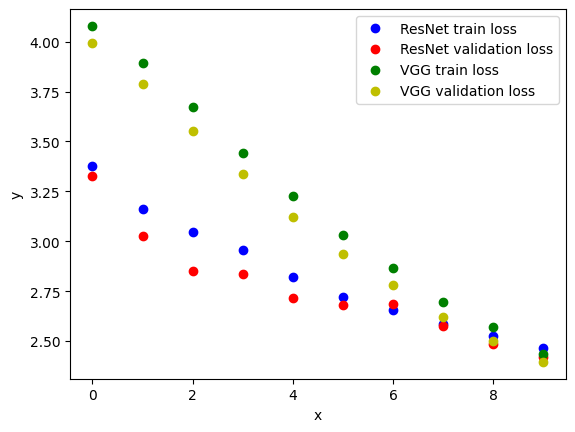

In [111]:
plt.plot(np.arange(10), train_loss_resnet18, 'ob', label = 'ResNet train loss')
plt.plot(np.arange(10), test_loss_resnet18, 'or', label = 'ResNet validation loss')
plt.plot(np.arange(10), train_loss_vgg16, 'og', label = 'VGG train loss')
plt.plot(np.arange(10), test_loss_vgg16, 'oy', label = 'VGG validation loss')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [122]:
# сразу избавимся от aux_logits и необходимости переписывать train
model = tv.models.inception_v3(weights=None, init_weights=False, aux_logits=False, num_classes=62)
# model

In [123]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [124]:
# этот слой следует обучить
for param in model.fc.parameters():
    param.requires_grad = True

In [126]:
# Trainable params: 127,038
# summary(model.to(device), input_size=(3, 299, 299))

In [127]:
# убедимся, что на выходе 62 класса
model.fc

Linear(in_features=2048, out_features=62, bias=True)

In [128]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [129]:
# resize to 299 x 299 and crop to center
tf_inc = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.CenterCrop(299),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [130]:
inc_train_data = EMNIST(
    root='.',
    split='byclass',
    train=True,
    transform=tf_inc,
    target_transform=None,
    download=False
)

In [131]:
inc_test_data = EMNIST(
    root='.',
    split='byclass',
    train=False,
    transform=tf_inc,
    target_transform=None,
    download=False
)

In [132]:
# sampler not changed
BATCH_SIZE=62*4
dl_train = DataLoader(inc_train_data, pin_memory=True, sampler=trn_sampler, batch_size=BATCH_SIZE)
dl_test = DataLoader(inc_test_data, pin_memory=True, sampler=tst_sampler, batch_size=BATCH_SIZE)

In [133]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)

In [134]:
# 148 800 примеров для обучения за 10 эпох
train_loss_inc, test_loss_inc = train(model, dl_train, dl_test, trainer, num_epochs=10, iter_cnt=60)

--------------------
epoch 1, test_n 4960, loss 6.0165, train acc 0.061, test acc 0.047, test loss 4.270, time 82.5 sec
--------------------
epoch 2, test_n 4960, loss 3.4996, train acc 0.156, test acc 0.210, test loss 3.171, time 79.1 sec
--------------------
epoch 3, test_n 4960, loss 2.9493, train acc 0.253, test acc 0.260, test loss 2.784, time 76.6 sec
--------------------
epoch 4, test_n 4960, loss 2.7316, train acc 0.290, test acc 0.301, test loss 2.656, time 75.6 sec
--------------------
epoch 5, test_n 4960, loss 2.5331, train acc 0.336, test acc 0.368, test loss 2.425, time 78.5 sec
--------------------
epoch 6, test_n 4960, loss 2.3362, train acc 0.367, test acc 0.385, test loss 2.259, time 80.0 sec
--------------------
epoch 7, test_n 4960, loss 2.2567, train acc 0.381, test acc 0.367, test loss 2.251, time 78.7 sec
--------------------
epoch 8, test_n 4960, loss 2.1708, train acc 0.405, test acc 0.417, test loss 2.114, time 80.9 sec
--------------------
epoch 9, test_n 496

In [212]:
model = tv.models.densenet161(weights=None, num_classes=62)
# model (classifier): Linear(in_features=2208, out_features=62, bias=True)

In [213]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [214]:
# этот слой следует обучить
for param in model.classifier.parameters():
    param.requires_grad = True

In [215]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [217]:
# tinfo.summary(model, input_size=(1, 3, 224, 224))
# Trainable params: 136,958
# output 62

In [218]:
# resize to 224 x 224
tf_dens = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.CenterCrop(224),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [219]:
dens_train_data = EMNIST(
    root='.',
    split='byclass',
    train=True,
    transform=tf_dens,
    target_transform=None,
    download=False
)

In [220]:
dens_test_data = EMNIST(
    root='.',
    split='byclass',
    train=False,
    transform=tf_dens,
    target_transform=None,
    download=False
)

In [221]:
# sampler not changed
BATCH_SIZE=62*2
dl_train = DataLoader(dens_train_data, pin_memory=True, sampler=trn_sampler, batch_size=BATCH_SIZE)
dl_test = DataLoader(dens_test_data, pin_memory=True, sampler=tst_sampler, batch_size=BATCH_SIZE)

In [222]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)

In [223]:
# 10 x 100 x 124 = 124 000 примеров для обучения за 10 эпох
train_loss_dens, test_loss_dens = train(model, dl_train, dl_test, trainer, num_epochs=10, iter_cnt=100)

--------------------
epoch 1, test_n 2480, loss 6.6640, train acc 0.098, test acc 0.174, test loss 3.207, time 41.7 sec
--------------------
epoch 2, test_n 2480, loss 3.1120, train acc 0.234, test acc 0.306, test loss 2.902, time 38.8 sec
--------------------
epoch 3, test_n 2480, loss 2.8099, train acc 0.293, test acc 0.341, test loss 2.577, time 35.9 sec
--------------------
epoch 4, test_n 2480, loss 2.4910, train acc 0.362, test acc 0.402, test loss 2.293, time 35.8 sec
--------------------
epoch 5, test_n 2480, loss 2.3894, train acc 0.384, test acc 0.406, test loss 2.185, time 36.5 sec
--------------------
epoch 6, test_n 2480, loss 2.3036, train acc 0.398, test acc 0.412, test loss 2.279, time 38.0 sec
--------------------
epoch 7, test_n 2480, loss 2.1814, train acc 0.430, test acc 0.445, test loss 2.126, time 37.6 sec
--------------------
epoch 8, test_n 2480, loss 2.1607, train acc 0.438, test acc 0.492, test loss 2.059, time 40.5 sec
--------------------
epoch 9, test_n 248

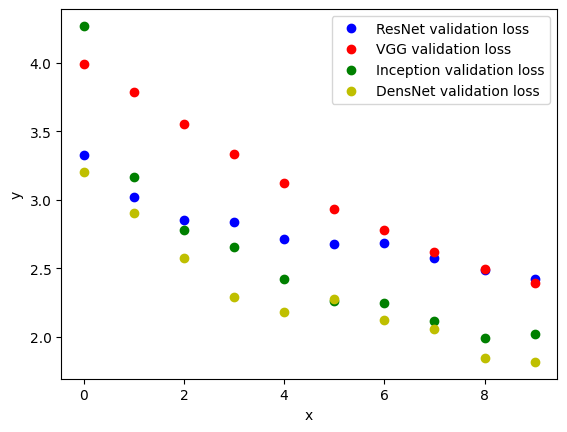

In [225]:
plt.plot(np.arange(10), test_loss_resnet18, 'ob', label = 'ResNet validation loss')
plt.plot(np.arange(10), test_loss_vgg16, 'or', label = 'VGG validation loss')
plt.plot(np.arange(10), test_loss_inc, 'og', label = 'Inception validation loss')
plt.plot(np.arange(10), test_loss_dens, 'oy', label = 'DensNet validation loss')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [226]:
# Лучшие показатели обучаемости у DensNet, однако, надо отметить, что нагрузка на комп кратно возрастала.

In [229]:
import pandas as pd

In [232]:
df = pd.DataFrame(
    {
        'ResNet': test_loss_resnet18,
        'VGG': test_loss_vgg16,
        'Inception': test_loss_inc,
        'DensNet': test_loss_dens
    },
    index = pd.RangeIndex(1, 11)
)

In [233]:
df

,ResNet,VGG,Inception,DensNet
1,3.326115,3.993319,4.270373,3.207435
2,3.024475,3.789137,3.170897,2.901554
3,2.852667,3.553175,2.783753,2.576824
4,2.835800,3.337988,2.655618,2.292868
5,2.717551,3.122512,2.424893,2.184949
6,2.680651,2.935810,2.258764,2.279374
7,2.684014,2.782053,2.250511,2.126157
8,2.573885,2.618844,2.113775,2.058982
9,2.486901,2.499459,1.990570,1.846874
10,2.420169,2.395699,2.024007,1.817526


In [234]:
# Inception потребляет меньших системных ресурсов, но немного отстает в скорости обучения в сравнении с DensNet.